# MODIS Snow Cover Data Processing with Dask and Azure Blob Storage

## Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
from azure.storage.blob import BlobServiceClient
import easysnowdata
import modis_masking
import coiled
import tqdm
import dask
from dask.distributed import Client, wait
import numcodecs
import concurrent.futures
import os
import logging
import traceback
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import odc.stac
import getpass
import adlfs
import json

odc.stac.configure_rio(cloud_defaults=True)

## Configuration

In [2]:
WY_start = 2015
WY_end = 2023

# get token from https://github.com/egagli/azure_authentication/raw/main/sas_token.txt
sas_token = getpass.getpass()

store = adlfs.AzureBlobFileSystem(account_name="snowmelt", credential=sas_token).get_mapper("snowmelt/snow_mask/global_modis_snow_mask.zarr")

## Prepare and visualize MODIS Grid

In [3]:
modis_grid = gpd.read_file('zip+http://book.ecosens.org/wp-content/uploads/2016/06/modis_grid.zip!modis_sinusoidal_grid_world.shp')
land = gpd.read_file(geodatasets.get_url('naturalearth land'))
land_modis_crs = gpd.GeoSeries(land.union_all(), crs='EPSG:4326').to_crs(modis_grid.crs)
modis_grid_land_idx = modis_grid.intersects(land_modis_crs.union_all())
modis_grid_land_idx[600] = False
modis_grid_land = modis_grid[modis_grid_land_idx]
modis_grid_not_land = modis_grid[~modis_grid_land_idx]
modis_grid_land_list = list(modis_grid_land.iterrows())
tile_processing_list = [f'h{tile["h"]}_v{tile["v"]}' for _, tile in modis_grid_land_list]

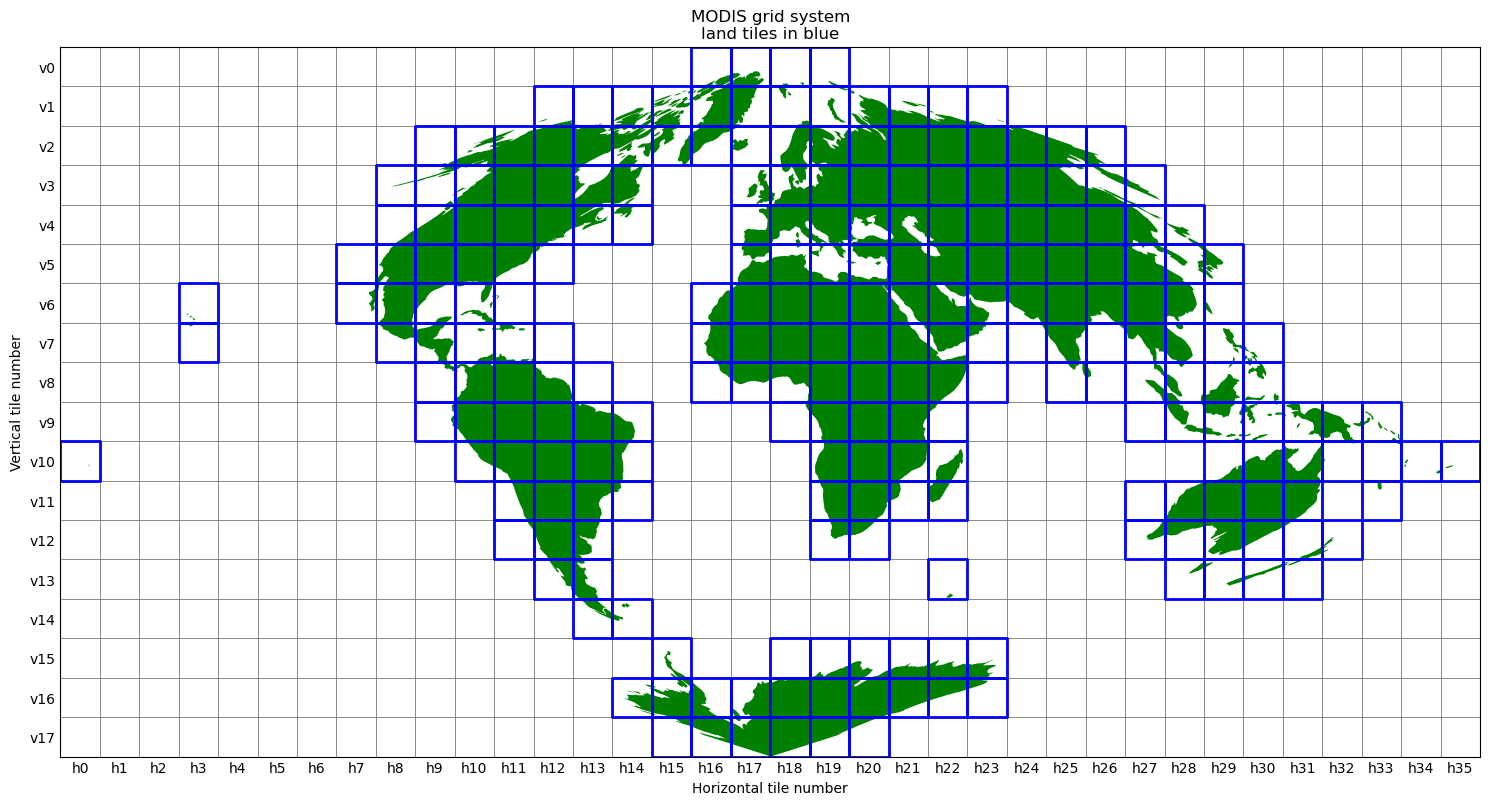

In [4]:
f, ax = plt.subplots(figsize=(15,15))
land_modis_crs.plot(ax=ax, color='green')
modis_grid_not_land.geometry.boundary.plot(ax=ax, color='gray', linewidth=0.5)
modis_grid_land.geometry.boundary.plot(ax=ax, color='blue', linewidth=2)

h_values = sorted(modis_grid['h'].unique())
v_values = sorted(modis_grid['v'].unique(), reverse=True)

h_coords = [modis_grid[modis_grid['h'] == h].geometry.centroid.x.mean() for h in h_values]
v_coords = [modis_grid[modis_grid['v'] == v].geometry.centroid.y.mean() for v in v_values]

ax.set_xticks(h_coords)
ax.set_xticklabels([f'h{h}' for h in h_values])
ax.set_yticks(v_coords)
ax.set_yticklabels([f'v{v}' for v in v_values])

ax.tick_params(axis='both', which='both', length=0)


ax.set_title('MODIS grid system\nland tiles in blue')
ax.set_xlabel('Horizontal tile number')
ax.set_ylabel('Vertical tile number')

ax.set_xlim(modis_grid.total_bounds[0], modis_grid.total_bounds[2])
ax.set_ylim(modis_grid.total_bounds[1], modis_grid.total_bounds[3])


ax.set_title('MODIS grid system\nland tiles in blue')
f.tight_layout()


## Define Processing Functions


In [5]:
def create_azure_zarr_store(store):

    water_years = np.arange(WY_start, WY_end + 1)
    num_years = len(water_years)


    modis_snow_entire_extent_footprint = modis_masking.get_modis_MOD10A2_full_grid()
    y = modis_snow_entire_extent_footprint.y.values
    x = modis_snow_entire_extent_footprint.x.values


    shape = (num_years, 18 * 2400, 36 * 2400)
    chunks = (1, 2400, 2400)  

    fill_value = np.iinfo(np.int16).min

    ds = xr.Dataset(
        {
            'SAD_DOWY': (('water_year', 'y', 'x'), dask.array.full(shape, fill_value=fill_value, chunks=chunks, dtype=np.int16)),
            'SDD_DOWY': (('water_year', 'y', 'x'), dask.array.full(shape, fill_value=fill_value, chunks=chunks, dtype=np.int16)),
            'max_consec_snow_days': (('water_year', 'y', 'x'), dask.array.full(shape, fill_value=fill_value, chunks=chunks, dtype=np.int16)),
        },
        coords={
            'water_year': water_years,
            'y': y,
            'x': x,
        }
    )

    ds.water_year.attrs['description'] = ("Water year. In northern hemisphere, water year starts on October 1st "
                                    "and ends on September 30th. For the southern hemisphere, water year "
                                    "starts on April 1st and ends on March 31st. e.g. in NH WY 2015 is "
                                    "[2014-10-01,2015-09-30] and in SH WY 2015 is [2015-04-01,2016-03-31].")
    
    ds.attrs['processed_tiles'] = []


    encoding = {var: {'chunks': chunks, 'compressor': zarr.Blosc(cname='zstd', clevel=3, shuffle=zarr.Blosc.SHUFFLE)}
                for var in ds.data_vars}
    

    ds.rio.write_crs(modis_snow_entire_extent_footprint.rio.crs, inplace=True)

    # https://github.com/pydata/xarray/issues/6288#issuecomment-1230970216
    for var in ds.data_vars:
        ds[str(var)].attrs['grid_mapping'] = 'spatial_ref' 
    

    ds.to_zarr(store, mode='w', encoding=encoding, compute=False, consolidated=True)

    return ds


In [13]:
def process_tile(tile, store):
    
    h, v = (int(part[1:]) for part in tile.split('_'))

    odc.stac.configure_rio(cloud_defaults=True)
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    logging.getLogger('azure').setLevel(logging.WARNING)

    logger.info(f"Starting process for tile {tile}")


    try:

        #logger.info(f"Zarr store opened successfully")

        hemisphere = "northern" if v < 9 else "southern"

        #logger.info(f"Fetching MODIS data for tile {tile}")
        if hemisphere == "northern":
            modis_snow_da = modis_masking.get_modis_MOD10A2_max_snow_extent(
                vertical_tile=v,
                horizontal_tile=h,
                start_date=f"{WY_start-1}-10-01",
                end_date=f"{WY_end}-09-30",
                chunks={"time": -1, "y": 480, "x": 480},
            )

        else:
            modis_snow_da = modis_masking.get_modis_MOD10A2_max_snow_extent(
                vertical_tile=v,
                horizontal_tile=h,
                start_date=f"{WY_start}-04-01",
                end_date=f"{WY_end+1}-03-31",
                chunks={"time": -1, "y": 480, "x": 480},
            )

        #logger.info(f"Processing MODIS data for tile {tile}")
        modis_snow_da.coords["water_year"] = (
            "time",
            pd.to_datetime(modis_snow_da.time).map(
                lambda x: easysnowdata.utils.datetime_to_WY(x, hemisphere=hemisphere)
            ),
        )
        modis_snow_da.coords["DOWY"] = (
            "time",
            pd.to_datetime(modis_snow_da.time).map(
                lambda x: easysnowdata.utils.datetime_to_DOWY(x, hemisphere=hemisphere)
            ),
        )

        modis_snow_da = modis_snow_da[
            (modis_snow_da.water_year >= WY_start) & (modis_snow_da.water_year <= WY_end)
        ]

        #logger.info(f"Applying binarize_with_cloud_filling for tile {tile}")
        effective_snow_da = modis_masking.binarize_with_cloud_filling(modis_snow_da)

        #logger.info(f"Calculating seasonal snow presence for tile {tile}")
        seasonal_snow_presence = effective_snow_da.groupby("water_year").apply(
            modis_masking.get_max_consec_snow_days_SAD_SDD_one_WY
        )

        #logger.info(f"Writing results to zarr store for tile {tile}")

        num_years = len(seasonal_snow_presence.water_year)
        water_year_slice = slice(0, num_years)
        y_slice = slice(v * 2400, (v + 1) * 2400)
        x_slice = slice(h * 2400, (h + 1) * 2400)

        existing_ds = xr.open_zarr(store, consolidated=True)
        y_coords = existing_ds.y[y_slice].values
        x_coords = existing_ds.x[x_slice].values

        if np.allclose(y_coords, seasonal_snow_presence.y.values, atol=0.1) or np.allclose(x_coords, seasonal_snow_presence.x.values, atol=0.1):
            seasonal_snow_presence = seasonal_snow_presence.assign_coords(y=y_coords, x=x_coords)
        else:
            logger.error(f"y or x coordinates do not match for tile {tile}")
            raise ValueError(f"y or x coordinates do not match for tile {tile}")

        seasonal_snow_presence.drop_vars('spatial_ref').chunk({'water_year':1,'y':2400,'x':2400}).to_zarr(store, region="auto", mode="r+", consolidated=True)
        #logger.info(f"Tile {tile} processed and written successfully")
        #existing_ds.attrs['processed_tiles'].append(tile)
        #logger.info(f"Tile {tile} processed and written, added to processed_tiles list")
        
        return True


    except Exception as e:
        logger.error(f"(PT) Error processing tile {tile}: {str(e)}")
        logger.error(f"(PT) Traceback: {traceback.format_exc()}")
        return False

In [8]:
start_fresh = False

if start_fresh == True:
    zarr_store_ds = create_azure_zarr_store(store)
    zarr_store_ds

## Set Up Dask Cluster with Coiled

In [19]:
cluster = coiled.Cluster(idle_timeout="15 minutes",
                         n_workers=[20,100],
                         worker_memory="8 GiB",
                         #worker_options={"nthreads": 8}, 
                         spot_policy="spot", 
                         environ={"GDAL_DISABLE_READDIR_ON_OPEN": "EMPTY_DIR"},
                         workspace="azure",
                         )
#cluster.adapt(minimum=10, maximum=100)
client = cluster.get_client()

Output()

INFO:coiled:Resolving your local sar_snowmelt_timing Python environment...


╭──────────────────────────────── Package Info ────────────────────────────────╮
│                                       ╷                                      │
│   Package                             │ Note                                 │
│ ╶─────────────────────────────────────┼────────────────────────────────────╴ │
│   coiled_local_MODIS_seasonal_snow_m… │ Source wheel built from              │
│                                       │ ~/repos/MODIS_seasonal_snow_mask     │
│   easysnowdata                        │ Wheel built from                     │
│                                       │ ~/repos/sar_snowmelt_timing/src/ea   │
│                                       │ sysnowdata                           │
│                                       ╵                                      │
╰──────────────────────────────────────────────────────────────────────────────╯

INFO:coiled:Creating Cluster (name: azure-41a97fbc, https://cloud.coiled.io/clusters/538188?account=azure ). This usually takes 1-2 minutes...


Output()

2024-07-27 11:39:58,512 - distributed.deploy.adaptive - INFO - Adaptive scaling started: minimum=20 maximum=100


2024-07-27 12:07:48,250 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
2024-07-27 12:07:48,516 - distributed.deploy.adaptive_core - ERROR - Adaptive stopping due to error
Traceback (most recent call last):
  File "/home/eric/.local/lib/python3.10/site-packages/distributed/comm/tcp.py", line 546, in connect
    stream = await self.client.connect(
  File "/home/eric/.local/lib/python3.10/site-packages/tornado/tcpclient.py", line 279, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/eric/miniconda3/envs/sar_snowmelt_timing/lib/python3.10/asyncio/tasks.py", line 456, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/er

## Process MODIS Tiles

In [20]:
failed_tiles = []


for tile in tqdm.tqdm(tile_processing_list):
    
    if tile in zarr.open(store).attrs['processed_tiles']:
        print(f"Tile {tile} already processed, skipping")
        continue
    
    client.restart()
    
    result = process_tile(tile, store)

    if result == True:

        with zarr.open(store) as zarr_store:
            processed_tile_list = zarr_store.attrs['processed_tiles']
            processed_tile_list.append(tile)
            zarr_store.attrs['processed_tiles'] = processed_tile_list

        print(f"Tile {tile} SUCCESS, added to processed_list attribute")


    else:
        print(f"Tile {tile} FAIL, adding to failed list")
        failed_tiles.append(tile)


if failed_tiles:
    print("Run this cell again. The following tiles could not be processed:")
    for tile in failed_tiles:
        print(tile)
else:
    print("Now consolidating metadata...")
    zarr.consolidate_metadata(store)
    print("All tiles processed successfully!!!")


  0%|          | 1/242 [00:03<15:31,  3.86s/it]

Tile h15_v17 already processed, skipping


  1%|          | 2/242 [00:04<08:50,  2.21s/it]

Tile h16_v17 already processed, skipping


  1%|          | 3/242 [00:06<07:03,  1.77s/it]

Tile h17_v17 already processed, skipping


  2%|▏         | 4/242 [00:07<06:51,  1.73s/it]

Tile h18_v17 already processed, skipping


  2%|▏         | 5/242 [00:08<05:52,  1.49s/it]

Tile h19_v17 already processed, skipping


  2%|▏         | 6/242 [00:10<05:45,  1.46s/it]

Tile h20_v17 already processed, skipping


  3%|▎         | 7/242 [00:11<05:13,  1.33s/it]

Tile h14_v16 already processed, skipping


  3%|▎         | 8/242 [00:12<04:50,  1.24s/it]

Tile h15_v16 already processed, skipping


  4%|▎         | 9/242 [00:13<04:36,  1.19s/it]

Tile h16_v16 already processed, skipping


  4%|▍         | 10/242 [00:14<04:25,  1.15s/it]

Tile h17_v16 already processed, skipping


  5%|▍         | 11/242 [00:15<04:25,  1.15s/it]

Tile h18_v16 already processed, skipping


  5%|▍         | 12/242 [00:17<04:39,  1.21s/it]

Tile h19_v16 already processed, skipping


  5%|▌         | 13/242 [00:18<04:27,  1.17s/it]

Tile h20_v16 already processed, skipping


  6%|▌         | 14/242 [00:19<04:17,  1.13s/it]

Tile h21_v16 already processed, skipping


  6%|▌         | 15/242 [00:20<04:13,  1.12s/it]

Tile h22_v16 already processed, skipping


  7%|▋         | 16/242 [00:21<04:08,  1.10s/it]

Tile h23_v16 already processed, skipping


  7%|▋         | 17/242 [00:22<04:04,  1.09s/it]

Tile h15_v15 already processed, skipping


  7%|▋         | 18/242 [00:23<04:05,  1.10s/it]

Tile h18_v15 already processed, skipping


  8%|▊         | 19/242 [00:24<04:04,  1.10s/it]

Tile h19_v15 already processed, skipping


  8%|▊         | 20/242 [00:25<03:59,  1.08s/it]

Tile h20_v15 already processed, skipping


  9%|▊         | 21/242 [00:26<03:56,  1.07s/it]

Tile h21_v15 already processed, skipping


  9%|▉         | 22/242 [00:27<03:54,  1.06s/it]

Tile h22_v15 already processed, skipping


 10%|▉         | 23/242 [00:28<03:52,  1.06s/it]

Tile h23_v15 already processed, skipping


 10%|▉         | 24/242 [00:29<03:52,  1.06s/it]

Tile h13_v14 already processed, skipping


 10%|█         | 25/242 [00:30<03:51,  1.07s/it]

Tile h14_v14 already processed, skipping


 11%|█         | 26/242 [00:31<03:50,  1.07s/it]

Tile h12_v13 already processed, skipping


 11%|█         | 27/242 [00:33<03:49,  1.07s/it]

Tile h13_v13 already processed, skipping


 12%|█▏        | 28/242 [00:34<03:50,  1.08s/it]

Tile h22_v13 already processed, skipping


 12%|█▏        | 29/242 [00:35<03:47,  1.07s/it]

Tile h28_v13 already processed, skipping


 12%|█▏        | 30/242 [00:36<03:45,  1.07s/it]

Tile h29_v13 already processed, skipping


 13%|█▎        | 31/242 [00:37<03:44,  1.06s/it]

Tile h30_v13 already processed, skipping


 13%|█▎        | 32/242 [00:38<03:42,  1.06s/it]

Tile h31_v13 already processed, skipping


 14%|█▎        | 33/242 [00:39<03:40,  1.06s/it]

Tile h11_v12 already processed, skipping


 14%|█▍        | 34/242 [00:40<03:39,  1.05s/it]

Tile h12_v12 already processed, skipping


 14%|█▍        | 35/242 [00:41<03:39,  1.06s/it]

Tile h13_v12 already processed, skipping


 15%|█▍        | 36/242 [00:42<03:38,  1.06s/it]

Tile h19_v12 already processed, skipping


 15%|█▌        | 37/242 [00:43<03:35,  1.05s/it]

Tile h20_v12 already processed, skipping


 16%|█▌        | 38/242 [00:44<03:35,  1.06s/it]

Tile h27_v12 already processed, skipping


 16%|█▌        | 39/242 [00:45<03:35,  1.06s/it]

Tile h28_v12 already processed, skipping


 17%|█▋        | 40/242 [00:47<03:51,  1.15s/it]

Tile h29_v12 already processed, skipping


 17%|█▋        | 41/242 [00:48<03:45,  1.12s/it]

Tile h30_v12 already processed, skipping


 17%|█▋        | 42/242 [00:49<03:42,  1.11s/it]

Tile h31_v12 already processed, skipping


 18%|█▊        | 43/242 [00:50<03:39,  1.10s/it]

Tile h32_v12 already processed, skipping


 18%|█▊        | 44/242 [00:51<03:37,  1.10s/it]

Tile h11_v11 already processed, skipping


 19%|█▊        | 45/242 [00:52<03:35,  1.09s/it]

Tile h12_v11 already processed, skipping


 19%|█▉        | 46/242 [00:53<03:32,  1.08s/it]

Tile h13_v11 already processed, skipping


 19%|█▉        | 47/242 [00:54<03:31,  1.09s/it]

Tile h14_v11 already processed, skipping


 20%|█▉        | 48/242 [00:55<03:40,  1.14s/it]

Tile h19_v11 already processed, skipping


 20%|██        | 49/242 [00:56<03:35,  1.11s/it]

Tile h20_v11 already processed, skipping


 21%|██        | 50/242 [00:58<03:30,  1.09s/it]

Tile h21_v11 already processed, skipping


 21%|██        | 51/242 [00:59<03:26,  1.08s/it]

Tile h22_v11 already processed, skipping


 21%|██▏       | 52/242 [01:00<03:24,  1.08s/it]

Tile h27_v11 already processed, skipping


 22%|██▏       | 53/242 [01:01<04:04,  1.29s/it]

Tile h28_v11 already processed, skipping


 22%|██▏       | 54/242 [01:03<03:59,  1.27s/it]

Tile h29_v11 already processed, skipping


 23%|██▎       | 55/242 [01:04<03:45,  1.20s/it]

Tile h30_v11 already processed, skipping


 23%|██▎       | 56/242 [01:05<03:37,  1.17s/it]

Tile h31_v11 already processed, skipping


 24%|██▎       | 57/242 [01:06<03:29,  1.13s/it]

Tile h33_v11 already processed, skipping


 24%|██▍       | 58/242 [01:07<03:23,  1.11s/it]

Tile h0_v10 already processed, skipping


 24%|██▍       | 59/242 [01:08<03:20,  1.09s/it]

Tile h10_v10 already processed, skipping


 25%|██▍       | 60/242 [01:10<03:56,  1.30s/it]

Tile h11_v10 already processed, skipping


 25%|██▌       | 61/242 [01:11<03:42,  1.23s/it]

Tile h12_v10 already processed, skipping


 26%|██▌       | 62/242 [01:12<03:32,  1.18s/it]

Tile h13_v10 already processed, skipping


 26%|██▌       | 63/242 [01:13<03:24,  1.14s/it]

Tile h14_v10 already processed, skipping


 26%|██▋       | 64/242 [01:14<03:35,  1.21s/it]

Tile h19_v10 already processed, skipping


 27%|██▋       | 65/242 [01:15<03:27,  1.17s/it]

Tile h20_v10 already processed, skipping


 27%|██▋       | 66/242 [01:17<03:40,  1.25s/it]

Tile h21_v10 already processed, skipping


 28%|██▊       | 67/242 [01:18<03:31,  1.21s/it]

Tile h22_v10 already processed, skipping


 28%|██▊       | 68/242 [01:19<03:38,  1.25s/it]

Tile h29_v10 already processed, skipping


 29%|██▊       | 69/242 [01:20<03:27,  1.20s/it]

Tile h30_v10 already processed, skipping


 29%|██▉       | 70/242 [01:21<03:19,  1.16s/it]

Tile h31_v10 already processed, skipping


 29%|██▉       | 71/242 [01:23<03:14,  1.13s/it]

Tile h32_v10 already processed, skipping


 30%|██▉       | 72/242 [01:24<03:09,  1.11s/it]

Tile h33_v10 already processed, skipping


 30%|███       | 73/242 [01:25<03:05,  1.10s/it]

Tile h34_v10 already processed, skipping


 31%|███       | 74/242 [01:26<03:24,  1.22s/it]

Tile h35_v10 already processed, skipping


 31%|███       | 75/242 [01:27<03:16,  1.18s/it]

Tile h9_v9 already processed, skipping


 31%|███▏      | 76/242 [01:28<03:09,  1.14s/it]

Tile h10_v9 already processed, skipping


 32%|███▏      | 77/242 [01:29<03:04,  1.12s/it]

Tile h11_v9 already processed, skipping


 32%|███▏      | 78/242 [01:30<03:00,  1.10s/it]

Tile h12_v9 already processed, skipping


 33%|███▎      | 79/242 [01:32<03:11,  1.18s/it]

Tile h13_v9 already processed, skipping


 33%|███▎      | 80/242 [01:33<03:25,  1.27s/it]

Tile h14_v9 already processed, skipping


 33%|███▎      | 81/242 [01:34<03:13,  1.20s/it]

Tile h18_v9 already processed, skipping


 34%|███▍      | 82/242 [01:35<03:05,  1.16s/it]

Tile h19_v9 already processed, skipping


 34%|███▍      | 83/242 [01:36<02:58,  1.12s/it]

Tile h20_v9 already processed, skipping


 35%|███▍      | 84/242 [01:37<02:54,  1.10s/it]

Tile h21_v9 already processed, skipping


 35%|███▌      | 85/242 [01:38<02:50,  1.09s/it]

Tile h22_v9 already processed, skipping


 36%|███▌      | 86/242 [01:40<02:48,  1.08s/it]

Tile h27_v9 already processed, skipping


 36%|███▌      | 87/242 [01:41<02:47,  1.08s/it]

Tile h28_v9 already processed, skipping


 36%|███▋      | 88/242 [01:42<02:44,  1.07s/it]

Tile h29_v9 already processed, skipping


 37%|███▋      | 89/242 [01:43<02:56,  1.15s/it]

Tile h30_v9 already processed, skipping


 37%|███▋      | 90/242 [01:44<02:49,  1.12s/it]

Tile h31_v9 already processed, skipping


 38%|███▊      | 91/242 [01:45<02:45,  1.10s/it]

Tile h32_v9 already processed, skipping


 38%|███▊      | 92/242 [01:46<02:42,  1.08s/it]

Tile h33_v9 already processed, skipping


 38%|███▊      | 93/242 [01:47<02:40,  1.07s/it]

Tile h9_v8 already processed, skipping


 39%|███▉      | 94/242 [01:48<02:40,  1.08s/it]

Tile h10_v8 already processed, skipping


 39%|███▉      | 95/242 [01:49<02:38,  1.08s/it]

Tile h11_v8 already processed, skipping


 40%|███▉      | 96/242 [01:50<02:37,  1.08s/it]

Tile h12_v8 already processed, skipping


 40%|████      | 97/242 [01:52<02:35,  1.07s/it]

Tile h13_v8 already processed, skipping


 40%|████      | 98/242 [01:53<02:33,  1.06s/it]

Tile h16_v8 already processed, skipping


 41%|████      | 99/242 [01:54<02:32,  1.07s/it]

Tile h17_v8 already processed, skipping


 41%|████▏     | 100/242 [01:55<02:31,  1.07s/it]

Tile h18_v8 already processed, skipping


 42%|████▏     | 101/242 [01:56<02:33,  1.09s/it]

Tile h19_v8 already processed, skipping


 42%|████▏     | 102/242 [01:57<02:31,  1.08s/it]

Tile h20_v8 already processed, skipping


 43%|████▎     | 103/242 [01:58<02:29,  1.08s/it]

Tile h21_v8 already processed, skipping


 43%|████▎     | 104/242 [01:59<02:27,  1.07s/it]

Tile h22_v8 already processed, skipping


 43%|████▎     | 105/242 [02:00<02:26,  1.07s/it]

Tile h23_v8 already processed, skipping


 44%|████▍     | 106/242 [02:01<02:24,  1.06s/it]

Tile h25_v8 already processed, skipping


 44%|████▍     | 107/242 [02:02<02:23,  1.06s/it]

Tile h26_v8 already processed, skipping


 45%|████▍     | 108/242 [02:03<02:24,  1.08s/it]

Tile h27_v8 already processed, skipping


 45%|████▌     | 109/242 [02:04<02:22,  1.07s/it]

Tile h28_v8 already processed, skipping


 45%|████▌     | 110/242 [02:06<02:34,  1.17s/it]

Tile h29_v8 already processed, skipping


 46%|████▌     | 111/242 [02:07<02:39,  1.22s/it]

Tile h30_v8 already processed, skipping


 46%|████▋     | 112/242 [02:08<02:32,  1.17s/it]

Tile h3_v7 already processed, skipping


 47%|████▋     | 113/242 [02:09<02:26,  1.13s/it]

Tile h8_v7 already processed, skipping


 47%|████▋     | 114/242 [02:10<02:22,  1.11s/it]

Tile h9_v7 already processed, skipping


 48%|████▊     | 115/242 [02:11<02:19,  1.10s/it]

Tile h10_v7 already processed, skipping


 48%|████▊     | 116/242 [02:12<02:16,  1.08s/it]

Tile h11_v7 already processed, skipping


 48%|████▊     | 117/242 [02:13<02:14,  1.07s/it]

Tile h12_v7 already processed, skipping


 49%|████▉     | 118/242 [02:15<02:12,  1.07s/it]

Tile h16_v7 already processed, skipping


 49%|████▉     | 119/242 [02:16<02:11,  1.07s/it]

Tile h17_v7 already processed, skipping


 50%|████▉     | 120/242 [02:17<02:10,  1.07s/it]

Tile h18_v7 already processed, skipping


 50%|█████     | 121/242 [02:18<02:11,  1.08s/it]

Tile h19_v7 already processed, skipping


 50%|█████     | 122/242 [02:19<02:20,  1.17s/it]

Tile h20_v7 already processed, skipping


 51%|█████     | 123/242 [02:20<02:16,  1.15s/it]

Tile h21_v7 already processed, skipping


 51%|█████     | 124/242 [02:21<02:14,  1.14s/it]

Tile h22_v7 already processed, skipping


 52%|█████▏    | 125/242 [02:22<02:10,  1.11s/it]

Tile h23_v7 already processed, skipping


 52%|█████▏    | 126/242 [02:24<02:08,  1.11s/it]

Tile h24_v7 already processed, skipping


 52%|█████▏    | 127/242 [02:25<02:27,  1.28s/it]

Tile h25_v7 already processed, skipping


 53%|█████▎    | 128/242 [02:29<03:44,  1.97s/it]

Tile h26_v7 already processed, skipping


 53%|█████▎    | 129/242 [02:31<03:47,  2.02s/it]

Tile h27_v7 already processed, skipping


 54%|█████▎    | 130/242 [02:35<04:42,  2.52s/it]

Tile h28_v7 already processed, skipping


 54%|█████▍    | 131/242 [02:41<06:58,  3.77s/it]

Tile h29_v7 already processed, skipping


 55%|█████▍    | 132/242 [02:42<05:25,  2.96s/it]

Tile h30_v7 already processed, skipping


 55%|█████▍    | 133/242 [02:44<04:25,  2.43s/it]

Tile h3_v6 already processed, skipping


 55%|█████▌    | 134/242 [02:45<03:38,  2.02s/it]

Tile h7_v6 already processed, skipping


 56%|█████▌    | 135/242 [02:46<03:05,  1.73s/it]

Tile h8_v6 already processed, skipping


 56%|█████▌    | 136/242 [02:47<02:41,  1.52s/it]

Tile h9_v6 already processed, skipping


 57%|█████▋    | 137/242 [02:48<02:25,  1.38s/it]

Tile h10_v6 already processed, skipping


 57%|█████▋    | 138/242 [02:49<02:13,  1.28s/it]

Tile h11_v6 already processed, skipping


 57%|█████▋    | 139/242 [02:50<02:14,  1.30s/it]

Tile h16_v6 already processed, skipping


 58%|█████▊    | 140/242 [02:51<02:05,  1.23s/it]

Tile h17_v6 already processed, skipping


 58%|█████▊    | 141/242 [02:52<01:59,  1.18s/it]

Tile h18_v6 already processed, skipping


 59%|█████▊    | 142/242 [02:53<01:54,  1.15s/it]

Tile h19_v6 already processed, skipping


 59%|█████▉    | 143/242 [02:54<01:50,  1.12s/it]

Tile h20_v6 already processed, skipping


 60%|█████▉    | 144/242 [02:55<01:47,  1.10s/it]

Tile h21_v6 already processed, skipping


 60%|█████▉    | 145/242 [02:57<01:45,  1.09s/it]

Tile h22_v6 already processed, skipping


 60%|██████    | 146/242 [02:58<01:43,  1.07s/it]

Tile h23_v6 already processed, skipping


 61%|██████    | 147/242 [02:59<01:42,  1.08s/it]

Tile h24_v6 already processed, skipping


 61%|██████    | 148/242 [03:00<01:40,  1.07s/it]

Tile h25_v6 already processed, skipping


 62%|██████▏   | 149/242 [03:01<01:39,  1.07s/it]

Tile h26_v6 already processed, skipping


 62%|██████▏   | 150/242 [03:02<01:37,  1.06s/it]

Tile h27_v6 already processed, skipping


 62%|██████▏   | 151/242 [03:03<01:35,  1.05s/it]

Tile h28_v6 already processed, skipping


 63%|██████▎   | 152/242 [03:04<01:35,  1.06s/it]

Tile h29_v6 already processed, skipping


 63%|██████▎   | 153/242 [03:05<01:34,  1.06s/it]

Tile h7_v5 already processed, skipping


 64%|██████▎   | 154/242 [03:06<01:33,  1.06s/it]

Tile h8_v5 already processed, skipping


 64%|██████▍   | 155/242 [03:07<01:32,  1.06s/it]

Tile h9_v5 already processed, skipping


INFO:__main__:Starting process for tile h10_v5
 64%|██████▍   | 156/242 [05:47<1:09:46, 48.68s/it]

Tile h10_v5 SUCCESS, added to processed_list attribute


 65%|██████▍   | 157/242 [05:48<48:43, 34.39s/it]  

Tile h11_v5 already processed, skipping


 65%|██████▌   | 158/242 [05:49<34:07, 24.38s/it]

Tile h12_v5 already processed, skipping


 66%|██████▌   | 159/242 [05:50<24:01, 17.37s/it]

Tile h17_v5 already processed, skipping


 66%|██████▌   | 160/242 [05:51<17:02, 12.46s/it]

Tile h18_v5 already processed, skipping


 67%|██████▋   | 161/242 [05:52<12:11,  9.03s/it]

Tile h19_v5 already processed, skipping


 67%|██████▋   | 162/242 [05:53<08:50,  6.63s/it]

Tile h20_v5 already processed, skipping


 67%|██████▋   | 163/242 [05:54<06:31,  4.95s/it]

Tile h21_v5 already processed, skipping


 68%|██████▊   | 164/242 [05:55<04:54,  3.77s/it]

Tile h22_v5 already processed, skipping


 68%|██████▊   | 165/242 [05:56<03:47,  2.95s/it]

Tile h23_v5 already processed, skipping


 69%|██████▊   | 166/242 [05:57<03:00,  2.38s/it]

Tile h24_v5 already processed, skipping


 69%|██████▉   | 167/242 [05:58<02:27,  1.97s/it]

Tile h25_v5 already processed, skipping


 69%|██████▉   | 168/242 [05:59<02:04,  1.68s/it]

Tile h26_v5 already processed, skipping


 70%|██████▉   | 169/242 [06:00<01:49,  1.50s/it]

Tile h27_v5 already processed, skipping


 70%|███████   | 170/242 [06:01<01:37,  1.36s/it]

Tile h28_v5 already processed, skipping


 71%|███████   | 171/242 [06:02<01:29,  1.26s/it]

Tile h29_v5 already processed, skipping


 71%|███████   | 172/242 [06:03<01:23,  1.20s/it]

Tile h8_v4 already processed, skipping


 71%|███████▏  | 173/242 [06:04<01:19,  1.15s/it]

Tile h9_v4 already processed, skipping


 72%|███████▏  | 174/242 [06:05<01:15,  1.11s/it]

Tile h10_v4 already processed, skipping


 72%|███████▏  | 175/242 [06:06<01:13,  1.10s/it]

Tile h11_v4 already processed, skipping


 73%|███████▎  | 176/242 [06:08<01:11,  1.08s/it]

Tile h12_v4 already processed, skipping


 73%|███████▎  | 177/242 [06:09<01:09,  1.07s/it]

Tile h13_v4 already processed, skipping


 74%|███████▎  | 178/242 [06:10<01:08,  1.06s/it]

Tile h14_v4 already processed, skipping


 74%|███████▍  | 179/242 [06:11<01:06,  1.05s/it]

Tile h17_v4 already processed, skipping


 74%|███████▍  | 180/242 [06:12<01:04,  1.05s/it]

Tile h18_v4 already processed, skipping


 75%|███████▍  | 181/242 [06:13<01:05,  1.07s/it]

Tile h19_v4 already processed, skipping


 75%|███████▌  | 182/242 [06:14<01:04,  1.07s/it]

Tile h20_v4 already processed, skipping


 76%|███████▌  | 183/242 [06:15<01:02,  1.06s/it]

Tile h21_v4 already processed, skipping


 76%|███████▌  | 184/242 [06:16<01:01,  1.06s/it]

Tile h22_v4 already processed, skipping


 76%|███████▋  | 185/242 [06:17<01:00,  1.06s/it]

Tile h23_v4 already processed, skipping


 77%|███████▋  | 186/242 [06:18<00:59,  1.05s/it]

Tile h24_v4 already processed, skipping


 77%|███████▋  | 187/242 [06:19<00:57,  1.05s/it]

Tile h25_v4 already processed, skipping


 78%|███████▊  | 188/242 [06:20<00:57,  1.06s/it]

Tile h26_v4 already processed, skipping


 78%|███████▊  | 189/242 [06:21<00:55,  1.05s/it]

Tile h27_v4 already processed, skipping


INFO:__main__:Starting process for tile h28_v4
 79%|███████▊  | 190/242 [08:48<38:47, 44.76s/it]

Tile h28_v4 SUCCESS, added to processed_list attribute


 79%|███████▉  | 191/242 [08:49<26:53, 31.64s/it]

Tile h8_v3 already processed, skipping


 79%|███████▉  | 192/242 [08:50<18:45, 22.51s/it]

Tile h9_v3 already processed, skipping


 80%|███████▉  | 193/242 [08:51<13:07, 16.06s/it]

Tile h10_v3 already processed, skipping


 80%|████████  | 194/242 [08:52<09:14, 11.56s/it]

Tile h11_v3 already processed, skipping


 81%|████████  | 195/242 [08:53<06:35,  8.41s/it]

Tile h12_v3 already processed, skipping


 81%|████████  | 196/242 [08:55<04:53,  6.38s/it]

Tile h13_v3 already processed, skipping


 81%|████████▏ | 197/242 [08:56<03:34,  4.77s/it]

Tile h14_v3 already processed, skipping


 82%|████████▏ | 198/242 [08:57<02:40,  3.65s/it]

Tile h17_v3 already processed, skipping


 82%|████████▏ | 199/242 [08:58<02:02,  2.86s/it]

Tile h18_v3 already processed, skipping


 83%|████████▎ | 200/242 [09:00<01:43,  2.45s/it]

Tile h19_v3 already processed, skipping


 83%|████████▎ | 201/242 [09:01<01:22,  2.02s/it]

Tile h20_v3 already processed, skipping


 83%|████████▎ | 202/242 [09:02<01:12,  1.82s/it]

Tile h21_v3 already processed, skipping


 84%|████████▍ | 203/242 [09:03<01:01,  1.58s/it]

Tile h22_v3 already processed, skipping


 84%|████████▍ | 204/242 [09:04<00:53,  1.42s/it]

Tile h23_v3 already processed, skipping


 85%|████████▍ | 205/242 [09:06<01:01,  1.65s/it]

Tile h24_v3 already processed, skipping


 85%|████████▌ | 206/242 [09:07<00:52,  1.47s/it]

Tile h25_v3 already processed, skipping


 86%|████████▌ | 207/242 [09:08<00:46,  1.33s/it]

Tile h26_v3 already processed, skipping


 86%|████████▌ | 208/242 [09:09<00:42,  1.24s/it]

Tile h27_v3 already processed, skipping


 86%|████████▋ | 209/242 [09:10<00:38,  1.17s/it]

Tile h9_v2 already processed, skipping


 87%|████████▋ | 210/242 [09:11<00:36,  1.13s/it]

Tile h10_v2 already processed, skipping


 87%|████████▋ | 211/242 [09:12<00:33,  1.09s/it]

Tile h11_v2 already processed, skipping


 88%|████████▊ | 212/242 [09:14<00:38,  1.29s/it]

Tile h12_v2 already processed, skipping


 88%|████████▊ | 213/242 [09:16<00:45,  1.56s/it]

Tile h13_v2 already processed, skipping


 88%|████████▊ | 214/242 [09:17<00:39,  1.41s/it]

Tile h14_v2 already processed, skipping


 89%|████████▉ | 215/242 [09:18<00:34,  1.29s/it]

Tile h15_v2 already processed, skipping


 89%|████████▉ | 216/242 [09:19<00:31,  1.21s/it]

Tile h16_v2 already processed, skipping


 90%|████████▉ | 217/242 [09:20<00:28,  1.16s/it]

Tile h17_v2 already processed, skipping


 90%|█████████ | 218/242 [09:21<00:26,  1.11s/it]

Tile h18_v2 already processed, skipping


 90%|█████████ | 219/242 [09:22<00:24,  1.09s/it]

Tile h19_v2 already processed, skipping


 91%|█████████ | 220/242 [09:23<00:23,  1.07s/it]

Tile h20_v2 already processed, skipping


 91%|█████████▏| 221/242 [09:25<00:26,  1.25s/it]

Tile h21_v2 already processed, skipping


 92%|█████████▏| 222/242 [09:26<00:23,  1.18s/it]

Tile h22_v2 already processed, skipping


INFO:__main__:Starting process for tile h23_v2
 92%|█████████▏| 223/242 [12:16<16:24, 51.84s/it]

Tile h23_v2 SUCCESS, added to processed_list attribute


 93%|█████████▎| 224/242 [12:17<10:58, 36.60s/it]

Tile h24_v2 already processed, skipping


 93%|█████████▎| 225/242 [12:18<07:20, 25.94s/it]

Tile h25_v2 already processed, skipping


 93%|█████████▎| 226/242 [12:20<04:57, 18.58s/it]

Tile h26_v2 already processed, skipping


 94%|█████████▍| 227/242 [12:21<03:19, 13.32s/it]

Tile h12_v1 already processed, skipping


 94%|█████████▍| 228/242 [12:22<02:14,  9.63s/it]

Tile h13_v1 already processed, skipping


 95%|█████████▍| 229/242 [12:23<01:31,  7.05s/it]

Tile h14_v1 already processed, skipping


 95%|█████████▌| 230/242 [12:24<01:03,  5.26s/it]

Tile h15_v1 already processed, skipping


 95%|█████████▌| 231/242 [12:25<00:44,  4.08s/it]

Tile h16_v1 already processed, skipping


 96%|█████████▌| 232/242 [12:26<00:31,  3.17s/it]

Tile h17_v1 already processed, skipping


 96%|█████████▋| 233/242 [12:28<00:23,  2.61s/it]

Tile h18_v1 already processed, skipping


 97%|█████████▋| 234/242 [12:29<00:17,  2.14s/it]

Tile h19_v1 already processed, skipping


 97%|█████████▋| 235/242 [12:30<00:12,  1.80s/it]

Tile h20_v1 already processed, skipping


 98%|█████████▊| 236/242 [12:31<00:09,  1.57s/it]

Tile h21_v1 already processed, skipping


 98%|█████████▊| 237/242 [12:32<00:07,  1.41s/it]

Tile h22_v1 already processed, skipping


 98%|█████████▊| 238/242 [12:33<00:05,  1.30s/it]

Tile h23_v1 already processed, skipping


 99%|█████████▉| 239/242 [12:34<00:03,  1.22s/it]

Tile h16_v0 already processed, skipping


 99%|█████████▉| 240/242 [12:35<00:02,  1.23s/it]

Tile h17_v0 already processed, skipping


100%|█████████▉| 241/242 [12:36<00:01,  1.27s/it]

Tile h18_v0 already processed, skipping


100%|██████████| 242/242 [12:37<00:00,  3.13s/it]

Tile h19_v0 already processed, skipping
Now consolidating metadata...


All tiles processed successfully!!!


## other approaches (code graveyard)

### serverless approach (this got close, couldn't push it across finish line though)

In [ ]:
# https://docs.coiled.io/user_guide/functions.html
# inspired by: https://github.com/earth-mover/serverless-datacube-demo/blob/main/src/lib.py

# maybe another option: https://xarray.dev/blog/cubed-xarray
# @coiled.function(
#     n_workers=50,
#     cpu=4,
#     #threads_per_worker=8,
#     memory="16GiB",
#     spot_policy="spot",
#     region="westeurope",
#     environ={"GDAL_DISABLE_READDIR_ON_OPEN": "EMPTY_DIR"},
#     keepalive="5m",
#     workspace="azure"
# )
# # def process_chunks(tile_list, store):
# #     odc.stac.configure_rio(cloud_defaults=True)
# #     results = []
# #     for _, tile in tile_list:
# #         h = tile['h']
# #         v = tile['v']
# #         result = process_and_write_tile(h, v, store, serverless=False)
# #         results.append(result)
# #     return results
# def process_chunk(tile, store):
#     odc.stac.configure_rio(cloud_defaults=True)
#     #with dask.config.set(pool=concurrent.futures.ThreadPoolExecutor(16), scheduler="threads"):
#     process = process_and_write_tile(tile, store, serverless=False)
#     return process


# def spawn_coiled_jobs(
#     modis_grid_land_list, store):
#     h_list = [tile['h'] for _, tile in modis_grid_land_list]
#     v_list = [tile['v'] for _, tile in modis_grid_land_list]
#     results = list(
#         tqdm.tqdm(
#             process_chunk.map(
#                 h_list, 
#                 v_list,
#                 store=store,
#                 retries=5
#             ),
#             total=len(h_list),
#             desc="Jobs Completed",
#         )
#     )
#     return results

# # def spawn_coiled_jobs(modis_grid_land_list, store, batch_size=10):
# #     batches = [modis_grid_land_list[i:i+batch_size] for i in range(0, len(modis_grid_land_list), batch_size)]
# #     results = list(
# #         tqdm.tqdm(
# #             process_chunks.map(
# #                 batches,
# #                 store=store,
# #                 retries=5
# #             ),
# #             total=len(batches),
# #             desc="Batch completed",
# #         )
# #     )
# #     return [item for sublist in results for item in sublist]

# #results = spawn_coiled_jobs(modis_grid_land_list, store)
# #results

In [ ]:
#futures = []
# # for _, tile in tqdm.tqdm(modis_grid_land_list):
# #     h = tile['h']
# #     v = tile['v']
# #     try:
# #         process_and_write_tile(h, v, store)
# #         print(f"Tile h{h}_v{v} processed and written")
# #     except Exception as e:
# #         print(f"Error processing tile h{h}_v{v}: {str(e)}")
# #         print(f"Traceback: {traceback.format_exc()}")
# #         # maybe append to a list of all tiles that need to be rerun
# #     #future = client.submit(process_and_write_tile, h, v, store)
# #     #futures.append(future)
# # #results = wait(futures)
# # 
# # for future in futures:
#     try:
#         result = future.result()
#         print(result)
#     except Exception as e:
#         print(f"Task failed: {str(e)}")
#         print(f"Traceback: {future.traceback()}")
# 
# 
# # client.close()
# cluster.close()
# 
#     #seasonal_snow_presence.drop_vars('spatial_ref').chunk({'water_year':1,'y':2400,'x':2400}).to_zarr(store, region={'water_year':water_year_slice,'y':y_slice,'x':x_slice}, mode="r+")

# if serverless:
#     print(f'running serverless mode, using threadpoolexecutor...')
#     with dask.config.set(pool=concurrent.futures.ThreadPoolExecutor(16), scheduler="threads"):
#         for var in ['SAD_DOWY', 'SDD_DOWY', 'max_consec_snow_days']:
#             data = seasonal_snow_presence[var].values
#             root[var][:,y_start:y_end,x_start:x_end] = data
# else:
#     for var in ['SAD_DOWY', 'SDD_DOWY', 'max_consec_snow_days']:
#         data = seasonal_snow_presence[var].values
#         root[var][:,y_start:y_end,x_start:x_end] = data

# root[:, time_slice, y_slice, x_slice] = data


    #root[var][time_slice, y_slice, x_slice] = data

# if data.shape[0] == 9 and data.shape[1] == 2400 and data.shape[2] == 2400:
#    print(f'transpose necessary h{h}_v{v}')
#    data = np.transpose(data, (1, 2, 0))


# store.flush()



# with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:  # Adjust number as needed
#     futures = [executor.submit(process_and_write_tile, h, v, azure_zarr_path) 
#                for h, v in modis_grid_land_list]

# def process_batch(batch):
#     results = []
#     for h, v in batch:
#         results.append(process_and_write_tile(h, v, azure_zarr_path))
#     return results

# batch_size = 10  # Adjust based on your workload
# batches = [modis_grid_land_list[i:i+batch_size] for i in range(0, len(modis_grid_land_list), batch_size)]
# futures = client.map(process_batch, batches)



# def create_azure_zarr_store(connection_string, container_name, zarr_store_path):
#     blob_service_client = BlobServiceClient.from_connection_string(connection_string)
#     container_client = blob_service_client.get_container_client(container_name)

#     class AzureBlobStore(zarr.ABSStore):
#         def __init__(self, container_client, prefix):
#             self.container_client = container_client
#             self.prefix = prefix
#             self.client = container_client  # Add this line

#         def __getitem__(self, key):
#             blob_client = self.container_client.get_blob_client(f"{self.prefix}/{key}")
#             return blob_client.download_blob().readall()

#         def __setitem__(self, key, value):
#             blob_client = self.container_client.get_blob_client(f"{self.prefix}/{key}")
#             blob_client.upload_blob(value, overwrite=True)

#         def __contains__(self, key):
#             blob_client = self.container_client.get_blob_client(f"{self.prefix}/{key}")
#             return blob_client.exists()

#         def __delitem__(self, key):
#             blob_client = self.container_client.get_blob_client(f"{self.prefix}/{key}")
#             blob_client.delete_blob()

#         def rmdir(self, path):
#             dir_path = self.prefix
#             if path:
#                 dir_path += "/" + path
#             dir_path += "/"
#             blobs_to_delete = self.container_client.list_blobs(
#                 name_starts_with=dir_path
#             )
#             for blob in blobs_to_delete:
#                 self.container_client.delete_blob(blob)

#     store = AzureBlobStore(container_client, zarr_store_path)

#     root = zarr.open(store, mode="w")
#     # root.create_dataset('SAD_DOWY', shape=(36 * 2400, 18 * 2400, len(range(WY_start, WY_end + 1))), chunks=(2400, 2400, 1), dtype='i2')
#     # root.create_dataset('SDD_DOWY', shape=(36 * 2400, 18 * 2400, len(range(WY_start, WY_end + 1))), chunks=(2400, 2400, 1), dtype='i2')
#     # root.create_dataset('max_consec_snow_days', shape=(36 * 2400, 18 * 2400, len(range(WY_start, WY_end + 1))), chunks=(2400, 2400, 1), dtype='i2')
#     water_years = list(range(WY_start, WY_end + 1))

#     num_years = len(water_years)

#     compressor = numcodecs.Blosc(
#         cname="zstd", clevel=3, shuffle=numcodecs.Blosc.SHUFFLE
#     )

#     # Create datasets
#     for var in ['SAD_DOWY', 'SDD_DOWY', 'max_consec_snow_days']:
#         dataset = root.create_dataset(
#             var,
#             shape=(num_years, 18 * 2400, 36 * 2400),
#             chunks=(1, 2400, 2400),
#             dtype="i2",
#             compressor=compressor,
#         )



#         # Add dimension names as attributes

#     #root.create_dataset("water_year", data=water_years, shape=(num_years,), dtype="i2")
#     # root["time"].attrs[
#     #     "description"
#     # ] = "Water year. In northern hemisphere, water year starts on October 1st and ends on September 30th. For the southern hemisphere, water year starts on April 1st and ends on March 31st. For example, in the northern hemisphere water year 2015 starts on October 1st, 2014 and ends on September 30th, 2015, and in the southern hemisphere water year 2015 starts on April 1st, 2015 and ends on March 31st, 2016."


#     return f"azure://{container_name}/{zarr_store_path}"

# from azure.core.exceptions import ResourceNotFoundError

# class AzureBlobStore(zarr.ABSStore):
#     def __init__(self, container_client, prefix):
#         self.container_client = container_client
#         self.prefix = prefix
#         self.client = container_client  # Add this line

#     def __getitem__(self, key):
#         blob_client = self.container_client.get_blob_client(f"{self.prefix}/{key}")
#         return blob_client.download_blob().readall()

#     def __setitem__(self, key, value):
#         blob_client = self.container_client.get_blob_client(f"{self.prefix}/{key}")
#         blob_client.upload_blob(value, overwrite=True)

#     def __contains__(self, key):
#         blob_client = self.container_client.get_blob_client(f"{self.prefix}/{key}")
#         return blob_client.exists()

#     def __delitem__(self, key):
#         blob_client = self.container_client.get_blob_client(f"{self.prefix}/{key}")
#         blob_client.delete_blob()

#     def rmdir(self, path):
#         dir_path = self.prefix
#         if path:
#             dir_path += "/" + path
#         dir_path += "/"
#         blobs_to_delete = self.container_client.list_blobs(
#             name_starts_with=dir_path
#         )
#         for blob in blobs_to_delete:
#             self.container_client.delete_blob(blob)


#blob_service_client = BlobServiceClient.from_connection_string(connection_string)
#container_client = blob_service_client.get_container_client(container_name)

#store = AzureBlobStore(container_client, zarr_store_path)
#root = zarr.open(store, mode="w")

#y = np.arange(0, 18 * 2400)
#x = np.arange(0, 36 * 2400)
    #connection_string = os.environ["azure-storage-connection-string"]
#parts = azure_zarr_path.split("/")

#container_name = parts[2]
#zarr_store_path = "/".join(parts[3:])

# blob_service_client = BlobServiceClient.from_connection_string(
#     connection_string
# )
#container_client = blob_service_client.get_container_client(container_name)

#store = AzureBlobStore(connection_string,container_client, zarr_store_path)
#root = zarr.open(store, mode="a")


# x_start, x_end = h * 2400, (h + 1) * 2400
# y_start, y_end = v * 2400, (v + 1) * 2400
        # with dask.config.set(pool=concurrent.futures.ThreadPoolExecutor(16), scheduler="threads"):
# data = seasonal_snow_presence[['SAD_DOWY', 'SDD_DOWY', 'max_consec_snow_days']].to_array().values

#'water_year':water_years,time_slice = slice(0, data.shape[0])
                #seasonal_snow_presence.drop_vars('spatial_ref').chunk({'water_year':num_years,'y':2400,'x':2400}).to_zarr(store, region={'water_year':water_year_slice,'y':y_slice,'x':x_slice}, mode="r+")


# def check_environment():
#     import sys
#     import os
#     result = {
#         "sys.path": sys.path,
#         "current_dir": os.getcwd(),
#         "list_dir": os.listdir(),
#         "env_vars": dict(os.environ),
#     }
#     try:
#         import easysnowdata
#         result["easysnowdata_version"] = easysnowdata.__version__
#     except ImportError as e:
#         result["easysnowdata_error"] = str(e)
#     try:
#         import modis_masking
#         result["modis_masking_file"] = modis_masking.__file__
#     except ImportError as e:
#         result["modis_masking_error"] = str(e)
#     return result

# # Run this on all workers
# environment_info = client.run(check_environment)

# # Print the results
# for worker, info in environment_info.items():
#     print(f"Worker {worker}:")
#     for key, value in info.items():
#         print(f"  {key}: {value}")
#     print()


# Set the Azure Blob Storage path for the zarr store
#container_name = "snowmelt"
#zarr_store_path = "modis_mask/global_modis_snow_mask.zarr"
#azure_zarr_path = f"azure://{container_name}/{zarr_store_path}"



# # Load progress
# progress = load_progress()
# processed_tiles = set(progress['processed'])
# failed_tiles = set(progress['failed'])

# # Load processed tiles from zarr
# zarr_store = zarr.open(store, mode='r')
# zarr_processed_tiles = set(zarr_store.attrs['processed_tiles'])



# failed_tiles = []

# def process_tile(tile, store):
#     result = process_and_write_tile(tile, store)
#     client.restart()  # Restart workers to clear memory
#     return result

# # First pass: process all tiles
# for tile in tqdm.tqdm(tile_processing_list):

#     try:
#         result = process_tile(tile, store)
#         print(f"Tile {tile} processed and written")
#     except Exception as e:
#         print(f"Error processing tile {tile}: {str(e)}")
#         print(f"Traceback: {traceback.format_exc()}")
#         failed_tiles.append(tile)

# # Second pass: retry failed tiles
# max_retries = 3
# retry_count = 0

# while failed_tiles and retry_count < max_retries:
#     retry_count += 1
#     print(f"Retry attempt {retry_count} for failed tiles")
#     still_failed = []
    
#     for tile in tqdm.tqdm(failed_tiles):
#         try:
#             result = process_tile(tile, store)
#             print(f"Tile {tile} processed and written on retry")
#         except Exception as e:
#             print(f"Error processing tile {tile} on retry: {str(e)}")
#             print(f"Traceback: {traceback.format_exc()}")
#             still_failed.append(tile)
    
#     failed_tiles = still_failed

# if failed_tiles:
#     print("The following tiles could not be processed after all retries:")
#     for tile in failed_tiles:
#         print(f"{tile}")

# client.close()
# cluster.close()